In [1]:
# Step 1: Imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.stats import entropy  # For noise measurement
import re

# Load data from Sheet2 (assume same file; adjust path if needed)
df = pd.read_excel('tweet_market_impact_new.xlsx', sheet_name='Sheet2', header=0)

# Sort by timestamp for sequential analysis
df = df.sort_values('Timestamp').reset_index(drop=True)  # Assume 'Timestamp' column

# Clean text if not already (remove links, etc.)
df['Tweet_clean'] = df['Tweet'].apply(lambda x: re.sub(r'http\S+|www\S+', '', str(x)).strip())

print("Data Loaded and Sorted. Shape:", df.shape)
df.head()

Data Loaded and Sorted. Shape: (162, 33)


,tweet_ID,Timestamp,Twitter_acc,Tweet,Mid_Open_Execution,Execution_Delayed,MI_1min_MidOpen,MI_1min_MidClose,MI_5min_MidOpen,MI_5min_MidClose,...,MI_12h_MidClose,MI_1d_MidOpen,MI_1d_MidClose,MI_2d_MidOpen,MI_2d_MidClose,MI_3d_MidOpen,MI_3d_MidClose,MI_4d_MidOpen,MI_4d_MidClose,Tweet_clean
0,13662,2025-06-12 17:41:00,WhiteHouse,MAKE AMERICA WEALTHY AGAIN 💸\n\nPresident Trum...,68.000,False,2.941176,-2.941176,-11.764706,-18.382353,...,947.794118,623.529412,612.500000,1302.205882,1256.617647,1302.205882,1256.617647,527.941176,524.264706,MAKE AMERICA WEALTHY AGAIN 💸\n\nPresident Trum...
1,3791,2025-06-12 17:48:00,mfa_russia,Honour the Past. Embrace the Future\n✍️Article...,67.855,False,3.684327,4.421192,2.947461,7.368654,...,903.396949,625.598703,620.440645,1326.357674,1280.672021,1326.357674,1280.672021,565.175742,557.070223,Honour the Past. Embrace the Future\n✍️Article...
2,7807,2025-06-12 17:51:00,WhiteHouse,HAPPENING NOW: @Sec_Noem hosts a press confere...,67.875,False,0.000000,-1.473297,19.889503,31.675875,...,895.027624,609.208103,620.994475,1323.020258,1277.348066,1323.020258,1277.348066,571.639042,574.585635,HAPPENING NOW: @Sec_Noem hosts a press confere...
3,4387,2025-06-12 17:54:00,mfa_russia,🎊The Embassy of Russia in South Africa hosted ...,67.905,False,7.363228,15.462779,48.597305,44.179368,...,871.069877,605.993668,607.466313,1318.017819,1272.365805,1318.017819,1272.365805,570.650173,577.277078,🎊The Embassy of Russia in South Africa hosted ...
4,3902,2025-06-12 17:55:00,WhiteHouse,"With @POTUS' economic plan, we’ll deliver seri...",67.955,False,8.093591,19.866088,36.789052,34.581708,...,838.054595,598.925760,608.490913,1309.690236,1264.071812,1309.690236,1264.071812,568.758737,576.116548,"With @POTUS' economic plan, we’ll deliver seri..."


In [2]:
# Step 2: Define oil-related keywords and topic detection
oil_keywords = ['Explosions', 'Tehran', 'Israel', 'Missile', 'Strike', 'WTI', 'oil', 'crude', 'energy', 'Iran', 'nuclear', 'Trump', 'Netanyahu']  # Expanded for better detection

# Function to flag oil-related tweets
def is_oil_topic(text):
    return any(word.lower() in text.lower() for word in oil_keywords)

df['is_oil_topic'] = df['Tweet_clean'].apply(is_oil_topic)

# ML Topic Modeling: Use TF-IDF + KMeans for clustering topics over time
vectorizer = TfidfVectorizer(lowercase=False, stop_words='english', max_features=200, min_df=1)
tfidf_matrix = vectorizer.fit_transform(df['Tweet_clean'])

# Cluster into topics (e.g., 5 clusters; adjust based on data)
kmeans = KMeans(n_clusters=5, random_state=42)
df['topic_cluster'] = kmeans.fit_predict(tfidf_matrix)

# Alternative: LDA for probabilistic topics
lda = LDA(n_components=5, random_state=42)
lda_topics = lda.fit_transform(tfidf_matrix)
df['lda_topic'] = np.argmax(lda_topics, axis=1)  # Dominant topic

print("Topic Detection Complete.")
df[['Tweet_clean', 'is_oil_topic', 'topic_cluster', 'lda_topic']].head(10)

Topic Detection Complete.


,Tweet_clean,is_oil_topic,topic_cluster,lda_topic
0,MAKE AMERICA WEALTHY AGAIN 💸\n\nPresident Trum...,True,4,2
1,Honour the Past. Embrace the Future\n✍️Article...,False,2,2
2,HAPPENING NOW: @Sec_Noem hosts a press confere...,False,0,3
3,🎊The Embassy of Russia in South Africa hosted ...,False,2,2
4,"With @POTUS' economic plan, we’ll deliver seri...",False,4,2
5,🚨 From the National Association of Manufacture...,False,4,1
6,"🗣️ ""It is already clear that energy efficiency...",True,0,3
7,TAKE POLL,False,0,0
8,Donald J. Trump Truth Social 06.12.25 02:03 PM...,True,0,0
9,AMERICA’S FRANCHISED DEALERS APPLAUD PRESIDENT...,True,0,2


Trade Entry Points (>=5 Accounts on Oil Topic):


,Timestamp,Twitter_acc,Tweet_clean,cumulative_oil_accounts,current_topic_accounts,lda_topic
42,2025-06-12 19:54:00,Yemenimilitary,In an article by the editor-in-chief of Haaret...,5,"Yemenimilitary, WhiteHouse, TrumpDailyPosts, I...",2
47,2025-06-12 20:48:00,chigrl,If you missed Catherine Yoshimoto from\n@FTSER...,6,"Yemenimilitary, WhiteHouse, chigrl, TrumpDaily...",2
62,2025-06-12 23:14:00,WhiteHouse,President Trump and the First Lady Participate...,6,"Yemenimilitary, WhiteHouse, chigrl, TrumpDaily...",2
68,2025-06-13 00:07:00,IntelDoge,"#Israel's Minister of Defense, Israel Katz, ha...",7,"Yemenimilitary, WhiteHouse, chigrl, TrumpDaily...",2
72,2025-06-13 00:20:00,TrumpDailyPosts,President Trump News Community - BREAKING,7,"Yemenimilitary, WhiteHouse, chigrl, TrumpDaily...",2
75,2025-06-13 00:21:00,chigrl,WTI hits 72.30 on @#$@ is getting real,7,"Yemenimilitary, WhiteHouse, chigrl, TrumpDaily...",2
76,2025-06-13 00:22:00,WhiteHouse,AMERICA FIRST — Chants of ‘USA’ rang out loud ...,7,"Yemenimilitary, WhiteHouse, chigrl, TrumpDaily...",2
77,2025-06-13 00:22:00,POTUS,AMERICA FIRST — Chants of ‘USA’ rang out loud ...,8,"Yemenimilitary, WhiteHouse, chigrl, POTUS, Tru...",2
78,2025-06-13 00:25:00,IntelDoge,"Trump convening cabinet level meeting shortly,...",8,"Yemenimilitary, WhiteHouse, chigrl, POTUS, Tru...",2
82,2025-06-13 00:44:00,chigrl,Not saying you should pay any attention to Nin...,8,"Yemenimilitary, WhiteHouse, chigrl, POTUS, Tru...",2


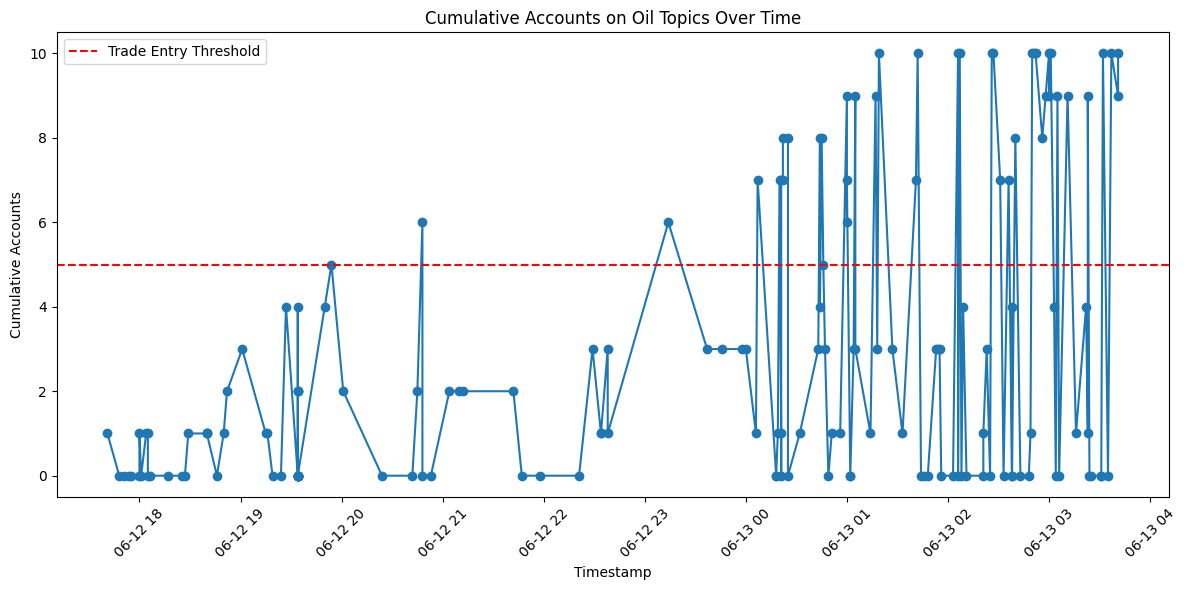

In [3]:
# Step 3: Sequential Analysis as Data Feed
# Cumulative tracking: Scan tweet by tweet, track accounts per topic
df['cumulative_oil_accounts'] = 0
df['current_topic_accounts'] = ''

# Dictionary to track accounts per topic (use cluster or LDA)
topic_accounts = {}  # topic: set of accounts

for idx, row in df.iterrows():
    topic = row['lda_topic']  # Or 'topic_cluster'
    acc = row['Twitter_acc']
    
    if row['is_oil_topic']:
        if topic not in topic_accounts:
            topic_accounts[topic] = set()
        topic_accounts[topic].add(acc)
        
        df.at[idx, 'cumulative_oil_accounts'] = len(topic_accounts[topic])
        df.at[idx, 'current_topic_accounts'] = ', '.join(topic_accounts[topic])
    
    # Reset if narrative shift (e.g., new day or logic for shift; simplify here)

# Trade entry: Where cumulative >=5
trade_entries = df[df['cumulative_oil_accounts'] >= 5]

print("Trade Entry Points (>=5 Accounts on Oil Topic):")
display(trade_entries[['Timestamp', 'Twitter_acc', 'Tweet_clean', 'cumulative_oil_accounts', 'current_topic_accounts', 'lda_topic']])

# Plot cumulative accounts over time
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['cumulative_oil_accounts'], marker='o')
plt.axhline(y=5, color='r', linestyle='--', label='Trade Entry Threshold')
plt.title('Cumulative Accounts on Oil Topics Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative Accounts')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Narrative Shift Points (Low Noise):


,Timestamp,Tweet_clean,word_diversity,lda_topic
0,2025-06-12 17:41:00,MAKE AMERICA WEALTHY AGAIN 💸\n\nPresident Trum...,3.204778,2
1,2025-06-12 17:48:00,Honour the Past. Embrace the Future\n✍️Article...,4.422581,2
2,2025-06-12 17:51:00,HAPPENING NOW: @Sec_Noem hosts a press confere...,4.586124,3
3,2025-06-12 17:54:00,🎊The Embassy of Russia in South Africa hosted ...,4.798012,2
4,2025-06-12 17:55:00,"With @POTUS' economic plan, we’ll deliver seri...",5.002544,2
5,2025-06-12 18:00:00,🚨 From the National Association of Manufacture...,5.102623,1
79,2025-06-13 00:25:00,"In the name of God, the Most Gracious, the Mos...",5.054967,3
81,2025-06-13 00:43:00,"#Israel'i media outlet @kann_news, quoting sec...",5.079278,1
112,2025-06-13 01:56:00,Absolutely insane scenes we're witnessing righ...,5.118837,3
121,2025-06-13 02:21:00,Another wave of airstrikes underway according ...,5.119862,4


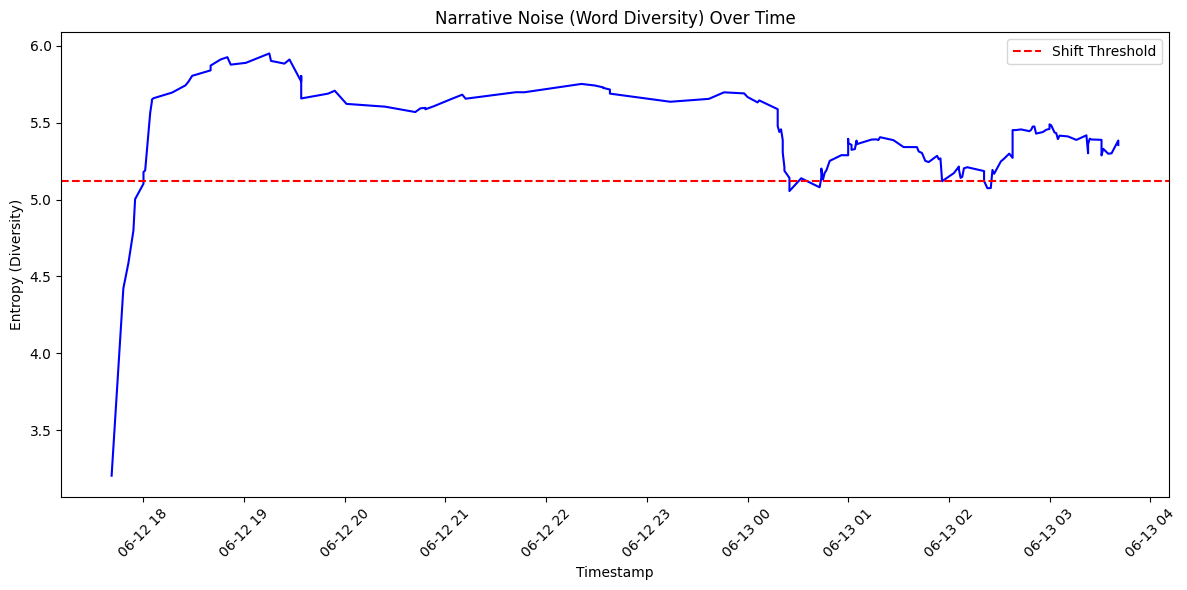

In [5]:
# Step 4: Narrative Shift Detection (Noise Reduction)
# Measure noise: Word diversity (entropy) in rolling windows
window_size = 20  # Tweets per window; adjust
df['word_diversity'] = 0.0

for i in range(len(df)):
    start = max(0, i - window_size + 1)
    window_text = ' '.join(df['Tweet_clean'].iloc[start:i+1])
    words = window_text.split()
    if words:
        word_counts = pd.Series(words).value_counts(normalize=True)
        df.at[i, 'word_diversity'] = entropy(word_counts)  # High entropy = high noise/diversity

# Shift point: Where diversity drops significantly (e.g., below mean - std)
mean_div = df['word_diversity'].mean()
std_div = df['word_diversity'].std()
shift_points = df[df['word_diversity'] < (mean_div - std_div)]

print("Narrative Shift Points (Low Noise):")
display(shift_points[['Timestamp', 'Tweet_clean', 'word_diversity', 'lda_topic']])

# Plot diversity over time
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['word_diversity'], color='b')
plt.axhline(y=mean_div - std_div, color='r', linestyle='--', label='Shift Threshold')
plt.title('Narrative Noise (Word Diversity) Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Entropy (Diversity)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Step 5: Integrate with Market Impact (MI Diffs from Baseline)
# Assume MI columns exist; compute diffs as before (move this earlier to ensure columns are created)
intervals = ['1min', '5min', '15min', '30min', '1h', '2h', '4h', '8h', '12h', '1d', '2d', '3d', '4d']
df['MI_Baseline'] = df.get('MI_1min_MidOpen', pd.Series(0, index=df.index))  # Fallback if missing
for interval in intervals[1:]:
    open_col = f'MI_{interval}_MidOpen'
    if open_col in df.columns:
        df[f'MI_{interval}_FromBaseline'] = df[open_col] - df['MI_Baseline']
    else:
        df[f'MI_{interval}_FromBaseline'] = np.nan  # Placeholder if column missing

diff_cols = [f'MI_{interval}_FromBaseline' for interval in intervals[1:] if f'MI_{interval}_FromBaseline' in df.columns]

# Check if trade_entries has rows; if empty, use full df or warn
if 'trade_entries' not in globals() or trade_entries.empty:
    print("No trade entries found; using full DF for MI diffs.")
    trade_entries = df.copy()  # Fallback to full DF

# At trade entries, show MI diffs (select only existing columns)
existing_diff_cols = [col for col in diff_cols if col in trade_entries.columns]
entry_mi = trade_entries[['Timestamp', 'Twitter_acc', 'Tweet_clean', 'cumulative_oil_accounts'] + existing_diff_cols]

print("MI Diffs at Trade Entries:")
display(entry_mi)


MI Diffs at Trade Entries:


,Timestamp,Twitter_acc,Tweet_clean,cumulative_oil_accounts
42,2025-06-12 19:54:00,Yemenimilitary,In an article by the editor-in-chief of Haaret...,5
47,2025-06-12 20:48:00,chigrl,If you missed Catherine Yoshimoto from\n@FTSER...,6
62,2025-06-12 23:14:00,WhiteHouse,President Trump and the First Lady Participate...,6
68,2025-06-13 00:07:00,IntelDoge,"#Israel's Minister of Defense, Israel Katz, ha...",7
72,2025-06-13 00:20:00,TrumpDailyPosts,President Trump News Community - BREAKING,7
75,2025-06-13 00:21:00,chigrl,WTI hits 72.30 on @#$@ is getting real,7
76,2025-06-13 00:22:00,WhiteHouse,AMERICA FIRST — Chants of ‘USA’ rang out loud ...,7
77,2025-06-13 00:22:00,POTUS,AMERICA FIRST — Chants of ‘USA’ rang out loud ...,8
78,2025-06-13 00:25:00,IntelDoge,"Trump convening cabinet level meeting shortly,...",8
82,2025-06-13 00:44:00,chigrl,Not saying you should pay any attention to Nin...,8
